In [48]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

paths = [['FER2013/train_FER2013', 'FER2013/validation_FER2013'], ['EiLA/EiLA_train', 'EiLA/EiLA_validation'], ['SFEW/Processed_Train_Faces', 'SFEW/Processed_Validation_Faces'], ['FER2013+10%EiLA/train', 'FER2013+10%EiLA/validation'], ['FER2013+30%EiLA/train', 'FER2013+30%EiLA/validation'], ['FER2013+50%EiLA/train', 'FER2013+50%EiLA/validation'],['FER2013+100%EiLA/train', 'FER2013+100%EiLA/validation'], ['SFEW+10%EiLA/train', 'SFEW+10%EiLA/validation'], ['SFEW+30%EiLA/train', 'SFEW+30%EiLA/validation'], ['SFEW+50%EiLA/train', 'SFEW+50%EiLA/validation'], ['SFEW+100%EiLA/train', 'SFEW+100%EiLA/validation']]
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
grandparent_dir = os.path.dirname(parent_dir)

# Load the demographics spreadsheet
demographics_df = pd.read_csv(os.path.join(grandparent_dir, 'EiLA/Extra/demographics.csv'))

In [49]:
import shutil

experiment = 2
train_dir = os.path.join(grandparent_dir, 'Experiment_Datasets', paths[experiment][0]) # select training dataset for this experiment
validation_dir = os.path.join(grandparent_dir, 'Experiment_Datasets', paths[experiment][1])  # select validation dataset for this experiment
test_dir = os.path.join(grandparent_dir, 'EiLA/Preprocessing/2.Resized_image/EiLA_test') # same for all experiments

print(train_dir)
print(validation_dir)

valid_emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

emotions = os.listdir(train_dir)

def clean_directory(directory, valid_emotions):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path) and item not in valid_emotions:
            shutil.rmtree(item_path)  # Remove invalid directories (e.g ipynb_checkpoints)
            
clean_directory(train_dir, valid_emotions)
clean_directory(validation_dir, valid_emotions)
clean_directory(test_dir, valid_emotions)

C:\Users\chena\Desktop\ResearchProject\Experiment_Datasets\SFEW/Processed_Train_Faces
C:\Users\chena\Desktop\ResearchProject\Experiment_Datasets\SFEW/Processed_Validation_Faces


In [50]:
from collections import defaultdict

def count_images(directory, valid_emotions):
    count = defaultdict(int)
    for emotion in valid_emotions:
        emotion_dir = os.path.join(directory, emotion)
        if os.path.isdir(emotion_dir):
            count[emotion] = len(os.listdir(emotion_dir))
    return count

train_counts = count_images(train_dir, valid_emotions)
valid_counts = count_images(validation_dir, valid_emotions)

print("Training set counts:", train_counts)
print("Validation set counts:", valid_counts)

Training set counts: defaultdict(<class 'int'>, {'Angry': 178, 'Disgust': 52, 'Fear': 78, 'Happy': 184, 'Neutral': 144, 'Sad': 161, 'Surprise': 94})
Validation set counts: defaultdict(<class 'int'>, {'Angry': 77, 'Disgust': 23, 'Fear': 46, 'Happy': 72, 'Neutral': 84, 'Sad': 73, 'Surprise': 56})


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import numpy as np

# Create a DataFrame to hold image paths and corresponding labels and demographics
def create_test_dataframe(data_dir, demographics_df):
    data = []
    for emotion in valid_emotions:
        emotion_dir = os.path.join(data_dir, emotion)
        if os.path.isdir(emotion_dir):
            for img_name in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_name)
                # Extract demographic information from file name
                id = img_name.split('.')[0].split('video_')[0].split('_label_')[0]
                label = img_name.split('.')[0].split('video_')[0].split('_label_')[1].split('_')[0]
                video_tag = img_name.split('.')[0].split('video_')[1].split('_clip_')[0]
                clip_id = int(img_name.split('.')[0].split('video_')[1].split('_clip_')[1].split('_person_')[0])
                person_id = int(img_name.split('.')[0].split('video_')[1].split('_clip_')[1].split('_person_')[1])       
                
                # Find the corresponding row in the demographics DataFrame
                demo_info = demographics_df[(demographics_df['Video Tag'] == video_tag) &
                                           (demographics_df['Clip Id'] == clip_id) &
                                           (demographics_df['Person Id'] == person_id)]
                if not demo_info.empty:
                    perceived_race = demo_info.iloc[0]['Perceived Race']
                    data.append((img_path, emotion, perceived_race))
    return pd.DataFrame(data, columns=['path', 'emotion', 'Skin_tone'])


datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_df = create_test_dataframe(test_dir, demographics_df)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

valid_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='path', 
    y_col='emotion',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

Found 891 images belonging to 7 classes.
Found 431 images belonging to 7 classes.
Found 815 validated image filenames belonging to 7 classes.


In [52]:
# test_df = create_test_dataframe('EiLA/EiLA_test', demographics_df)
test_df

,path,emotion,Skin_tone
0,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
1,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
2,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
3,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
4,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W
...,...,...,...
810,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W
811,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W
812,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W
813,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W


C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in 

Text(0, 0.5, 'Size')

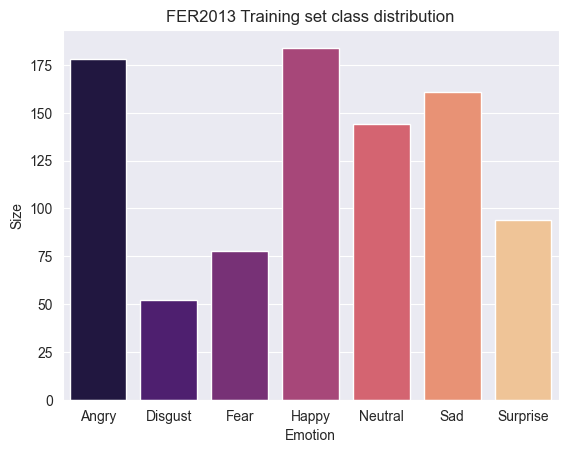

In [53]:
import matplotlib.pyplot as plt

emotions = os.listdir(train_dir)

train_counts = []

for emotion in emotions:
    if not emotion.endswith('checkpoints'):
        folder = os.path.join(train_dir, emotion)
        train_counts.append(len(os.listdir(folder)))

sns.barplot(x=emotions, y=train_counts, palette='magma').set_title("FER2013 Training set class distribution")
plt.xlabel('Emotion')
plt.ylabel('Size')


C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in 

<Axes: >

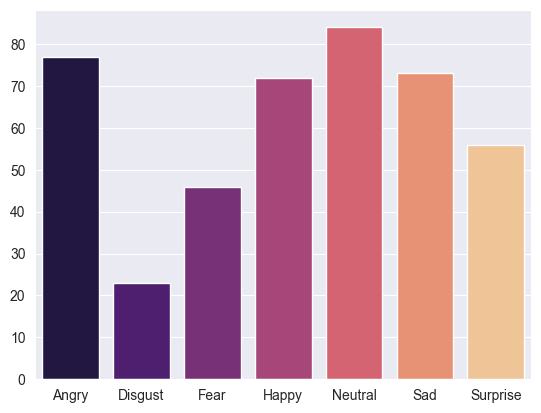

In [54]:
validation_counts = []

for emotion in emotions:
    folder = os.path.join(validation_dir, emotion)
    validation_counts.append(len(os.listdir(folder)))
    
sns.barplot(x=emotions, y=validation_counts, palette='magma')

In [55]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adamax, SGD
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Input, Dense, Dropout
from tensorflow.keras.models import Sequential

input_shape = (224, 224, 3)  

base_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [56]:
# Fit the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
)

Epoch 1/15


C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1172 - loss: 1.9706 - val_accuracy: 0.1879 - val_loss: 1.9405
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1906 - loss: 1.9211 - val_accuracy: 0.1833 - val_loss: 1.9223
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2527 - loss: 1.8817 - val_accuracy: 0.1763 - val_loss: 1.9131
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2799 - loss: 1.8514 - val_accuracy: 0.1972 - val_loss: 1.9053
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3016 - loss: 1.8482 - val_accuracy: 0.2042 - val_loss: 1.8989
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3374 - loss: 1.8114 - val_accuracy: 0.2227 - val_loss: 1.8914
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3709 - loss: 1.7812 - val_accuracy: 0.2320 - val_loss: 1.8838
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3720 - loss: 1.7620 - val_accuracy: 0.2227 - val_loss: 1.8759
Epo

In [57]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

In [58]:
# Unfreeze some layers in the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [59]:
optimizer = Adamax(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
# Fit the model
history = model.fit(
    train_generator,
    epochs=35,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3861 - loss: 1.6473 - val_accuracy: 0.2552 - val_loss: 1.8332 - learning_rate: 1.0000e-05
Epoch 2/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4547 - loss: 1.5933 - val_accuracy: 0.2413 - val_loss: 1.8351 - learning_rate: 1.0000e-05
Epoch 3/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4574 - loss: 1.5617 - val_accuracy: 0.2459 - val_loss: 1.8343 - learning_rate: 1.0000e-05
Epoch 4/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4485 - loss: 1.5722 - val_accuracy: 0.2552 - val_loss: 1.8322 - learning_rate: 1.0000e-05
Epoch 5/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4408 - loss: 1.5685 - val_accuracy: 0.2529 - val_loss: 1.8295 - learning_rate: 1.0000e-05
Epoch 6/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5086 - loss: 1.5124 - val_accuracy: 0.2483 - val_loss: 1.8265 - learning_rate: 1.0000e-05
Epoch 7/35
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4949 - loss:

26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 842ms/step
F1 Score: 0.2791141293915338
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 807ms/step - accuracy: 0.3214 - loss: 1.9845
loss: 1.9248682260513306
compile_metrics: 0.2662576735019684
              precision    recall  f1-score   support

       Angry       0.08      0.68      0.14        47
     Disgust       0.00      0.00      0.00        65
        Fear       0.22      0.11      0.14        76
       Happy       0.68      0.52      0.59       281
     Neutral       0.39      0.15      0.22       200
         Sad       0.00      0.00      0.00        57
    Surprise       0.00      0.00      0.00        89

    accuracy                           0.27       815
   macro avg       0.20      0.21      0.16       815
weighted avg       0.36      0.27      0.28       815


C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469

<Axes: >

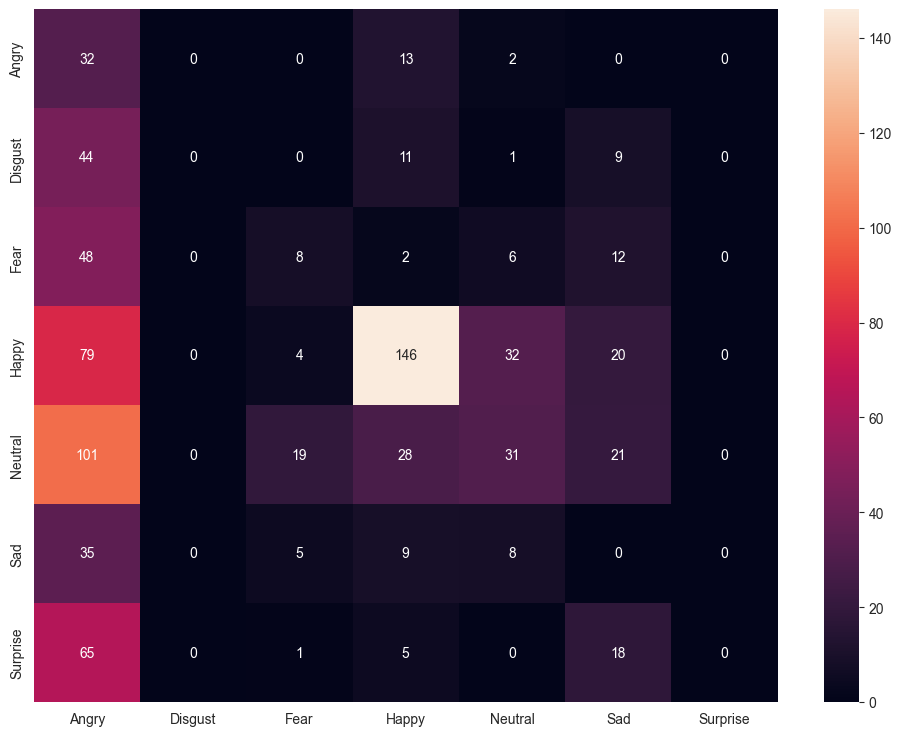

In [61]:
# import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

test_labels = test_generator.classes
test_pred_probs = model.predict(test_generator)
test_preds = np.argmax(test_pred_probs, axis=1)

# Compute the F1 score
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'F1 Score: {f1}')

# Evaluate the model on the test set
results = model.evaluate(test_generator)

# Print all the metrics
for name, value in zip(model.metrics_names, results):
    print(f'{name}: {value}')

# Print classification report
print(classification_report(test_labels, test_preds, target_names=valid_generator.class_indices.keys()))

# Print confusion matrix
cm = confusion_matrix(test_labels, test_preds)
df_cm = pd.DataFrame(cm, index=[i for i in emotions], columns=[i for i in emotions])
plt.figure(figsize=(12, 9))
plt.xlabel('Actual')
plt.ylabel('Predicted')
sns.heatmap(df_cm, annot=True, fmt='g')

In [62]:
import numpy as np

# Get predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Create a DataFrame for the test results
test_df['predicted'] = predicted_classes
test_df['true'] = true_classes

# Calculate accuracy for each ethnic group
represented_races = ['B', 'W', 'M']
ethnic_results = {}
# 
for group in represented_races:
    group_df = test_df[test_df['Skin_tone'] == group]
    print(f'Size of group: {len(group_df)}')
    correct_predictions = np.sum(group_df['predicted'] == group_df['true'])
    incorrect_predictions = len(group_df) - correct_predictions
    ethnic_results[group] = correct_predictions / (correct_predictions + incorrect_predictions) * 100
    
# Display the accuracy for each ethnic group
for group, accuracy in ethnic_results.items():
    print(f'Accuracy for {group}: {accuracy:.2f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 817ms/step
Size of group: 163
Size of group: 588
Size of group: 64
Accuracy for B: 41.10
Accuracy for W: 22.28
Accuracy for M: 29.69


In [63]:
correct_df = test_df[test_df['predicted'] == test_df['true']]
correct_df

incorrect_df = test_df[test_df['predicted'] != test_df['true']]
incorrect_df

,path,emotion,Skin_tone,predicted,true
4,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W,3,0
5,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W,3,0
6,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W,3,0
7,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W,3,0
21,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Angry,W,3,0
...,...,...,...,...,...
810,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W,0,6
811,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W,0,6
812,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W,0,6
813,C:\Users\chena\Desktop\ResearchProject\EiLA/Pr...,Surprise,W,0,6


In [64]:
experiment_name = paths[experiment][0].split('/')[0]

if 'FER2013' in experiment_name:
    experiment_group = 'FER2013'
else:
    experiment_group = 'SFEW'
    
print(os.path.join(grandparent_dir, 'Experiment_Output/' + experiment_group, paths[experiment][0].split('/')[0] + '_correct.csv'))
correct_df.to_csv(os.path.join(grandparent_dir, 'Experiment_Output/' + experiment_group, paths[experiment][0].split('/')[0] + '_correct.csv'), sep=',', index=False, encoding='utf-8', na_rep='N/A')
incorrect_df.to_csv(os.path.join(grandparent_dir, 'Experiment_Output/' + experiment_group, paths[experiment][0].split('/')[0] + '_incorrect.csv'), sep=',', index=False, encoding='utf-8', na_rep='N/A')

C:\Users\chena\Desktop\ResearchProject\Experiment_Output/SFEW\SFEW_correct.csv
